In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from statsmodels.graphics.mosaicplot import mosaic

import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



/kaggle/input/home-loan-approval/loan_sanction_test.csv
/kaggle/input/home-loan-approval/loan_sanction_train.csv


In [3]:
df = pd.read_csv('/kaggle/input/home-loan-approval/loan_sanction_train.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## Basic data exploration

In [4]:
df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


## Data Cleaning

In [6]:
df.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [7]:
# getting the total number of records that have atleast one null value
df.isna().any(axis=1).sum()

134

In [8]:
df_cleaned = df.copy()

In [9]:
# Imputation

df_cleaned.fillna({
    'Gender': df_cleaned['Gender'].mode()[0],
    'Married': df_cleaned['Married'].mode()[0],
    'Dependents': df_cleaned['Dependents'].mode()[0],
    'Self_Employed': df_cleaned['Self_Employed'].mode()[0],
    'LoanAmount': df_cleaned['LoanAmount'].mode()[0],
    'Loan_Amount_Term': df_cleaned['Loan_Amount_Term'].mode()[0],
    'Credit_History': df_cleaned['Credit_History'].mode()[0]
}, inplace=True)

In [10]:
# fixing data types
df_cleaned['Credit_History'] = df_cleaned['Credit_History'].astype(str)
df_cleaned['Credit_History']

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
609    1.0
610    1.0
611    1.0
612    1.0
613    0.0
Name: Credit_History, Length: 614, dtype: object

In [11]:
df_cleaned.drop(['Loan_ID'], axis=1, inplace=True)
df_cleaned.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

## EDA & Feature Engineering

In [12]:
target_col = 'Loan_Status'
numerical_features = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term']
categorical_features = [col for col in df_cleaned.columns if col not in numerical_features+[target_col]]

<Axes: xlabel='Loan_Status', ylabel='Count'>

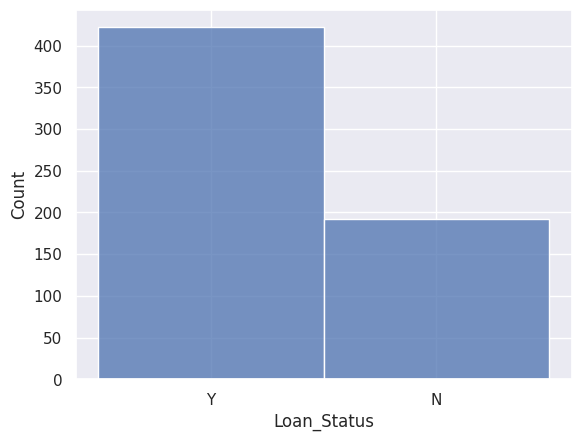

In [13]:
sns.histplot(x=target_col, data=df_cleaned)

### Categorical Variables

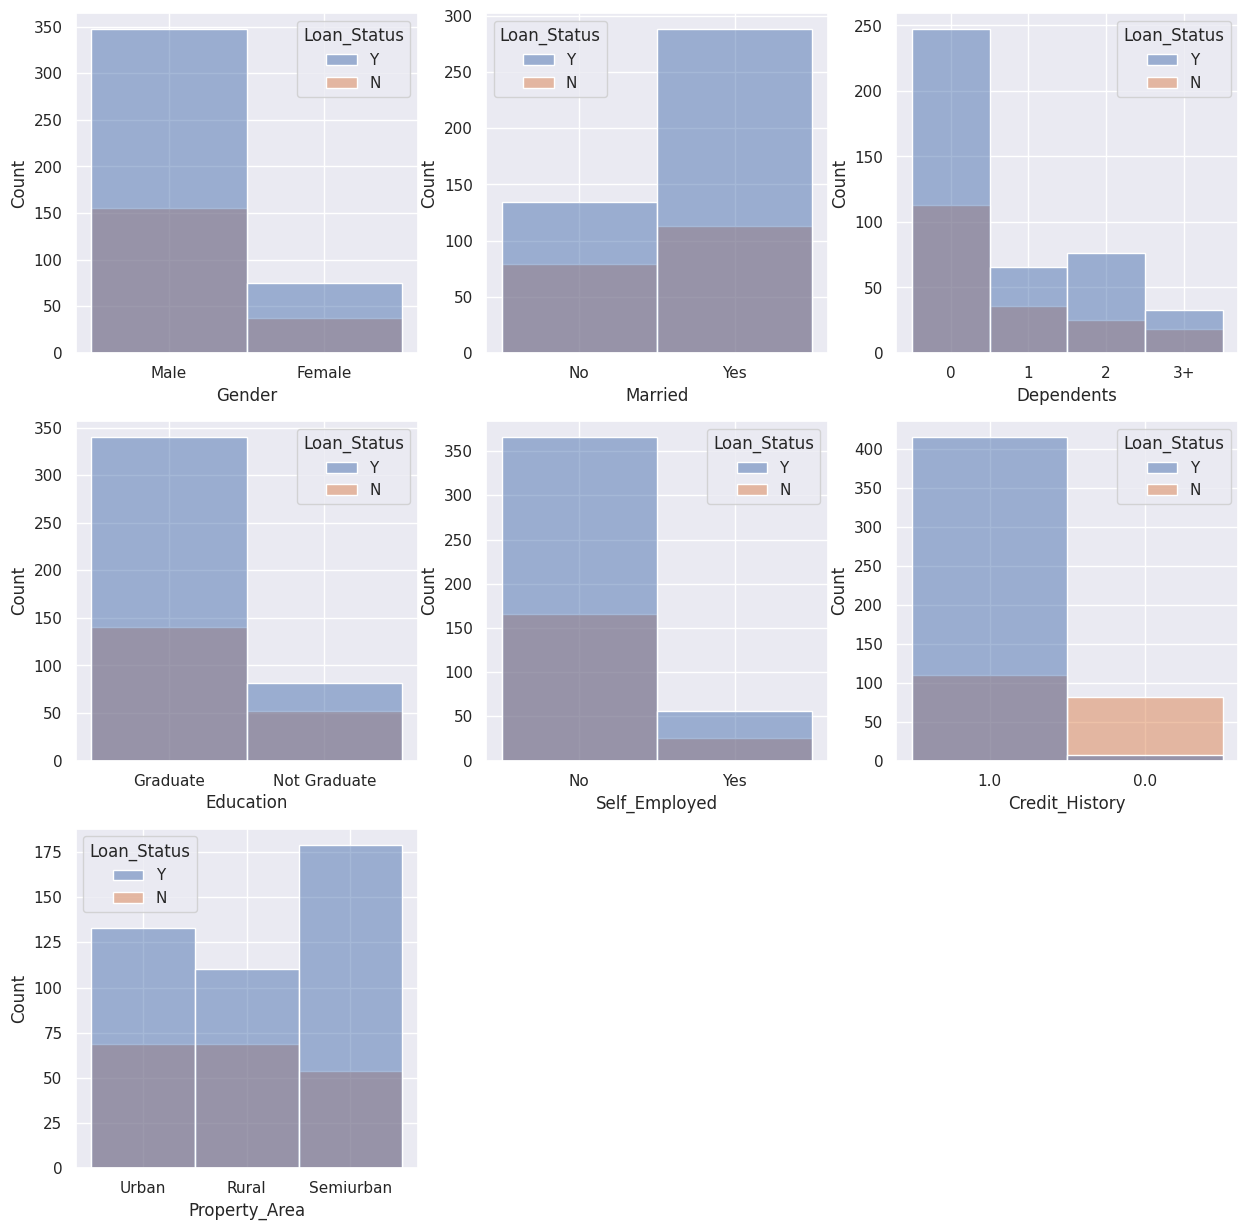

In [14]:
fig, axes = plt.subplots(3,3,figsize=(15,15))
for idx, ax in enumerate(axes.flat):
    if idx >= len(categorical_features):
        ax.remove()
        continue      
    sns.histplot(x=categorical_features[idx], hue=target_col, data=df_cleaned, ax=ax)

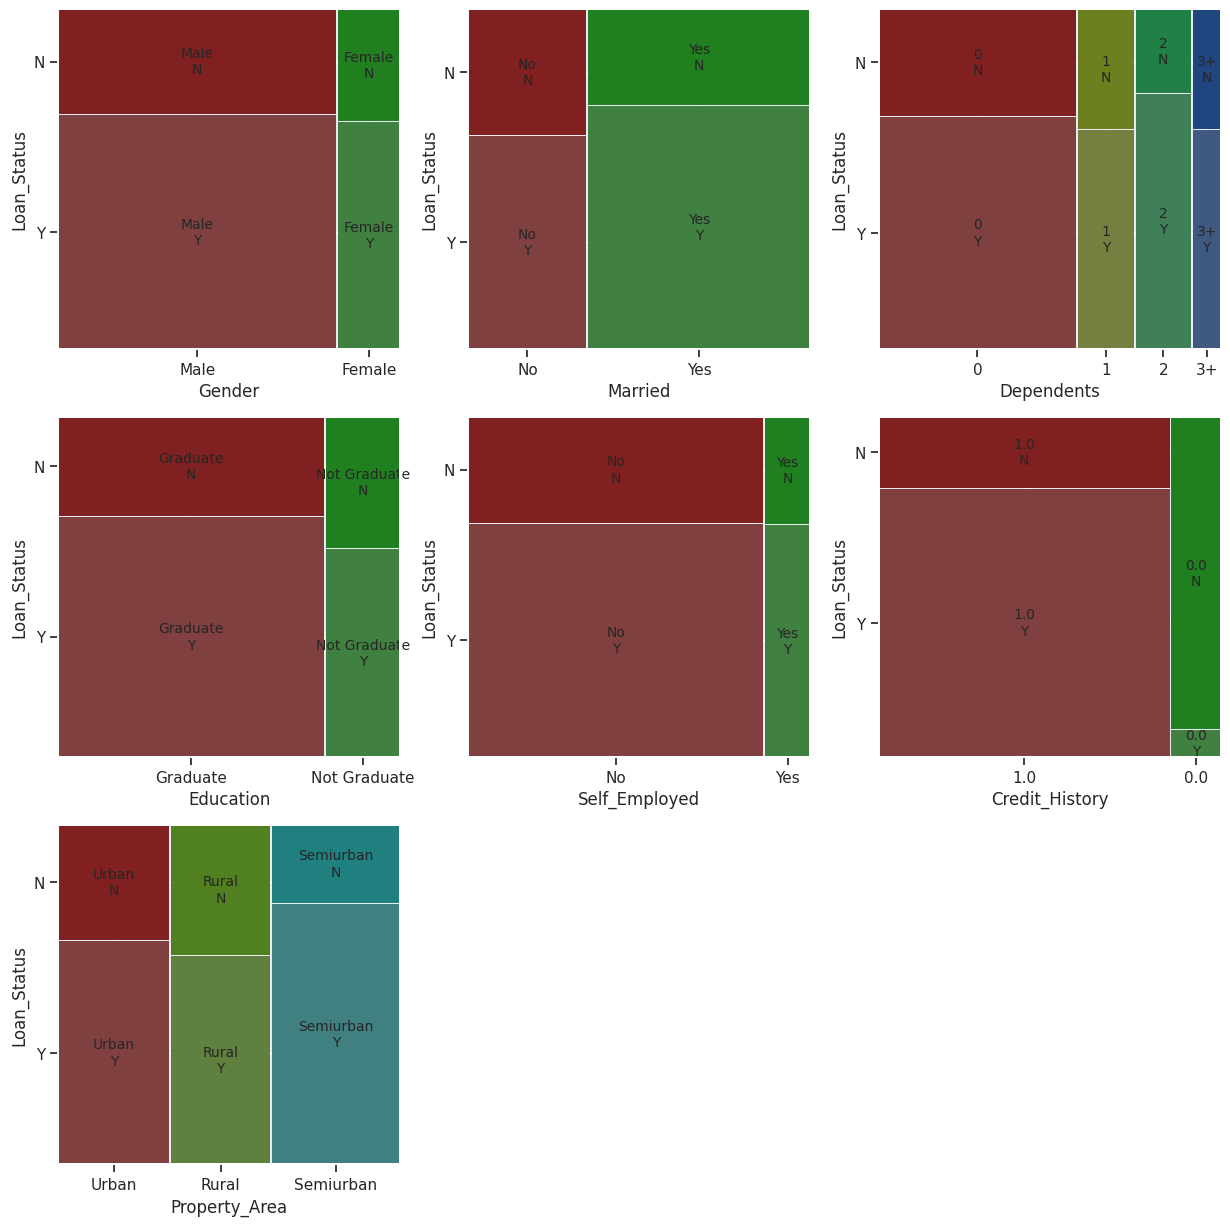

In [15]:
fig, axes = plt.subplots(3,3,figsize=(15,15))
for idx, ax in enumerate(axes.flat):
    if idx >= len(categorical_features):
        ax.remove()
        continue      
    mosaic(df_cleaned, [categorical_features[idx]]+[target_col], ax=ax)
    ax.set(xlabel=categorical_features[idx], ylabel=target_col)

we can see that some the features appear not to have or have a little effect on the response variable while others have significant relation for example:
* not having a `Credit_history` seems to have a terrible effect on approaving the loan.
* applicants with 2 `Dependents` seems to have a higher probability of getting theis loans approaved while having 3+ has the lowest number of approaved loans.
* applicants from rural `Property_Area` have the lowest number of approaved loans while applicants from semiurban areas have the highest. 

I am going to drop the variables `Gender` and `Self_Employed` as they appear to have absloutely no effect on the respone variable.

In [16]:
df_fe = df_cleaned.drop(['Gender', 'Self_Employed'], axis=1)

### Numerical variables

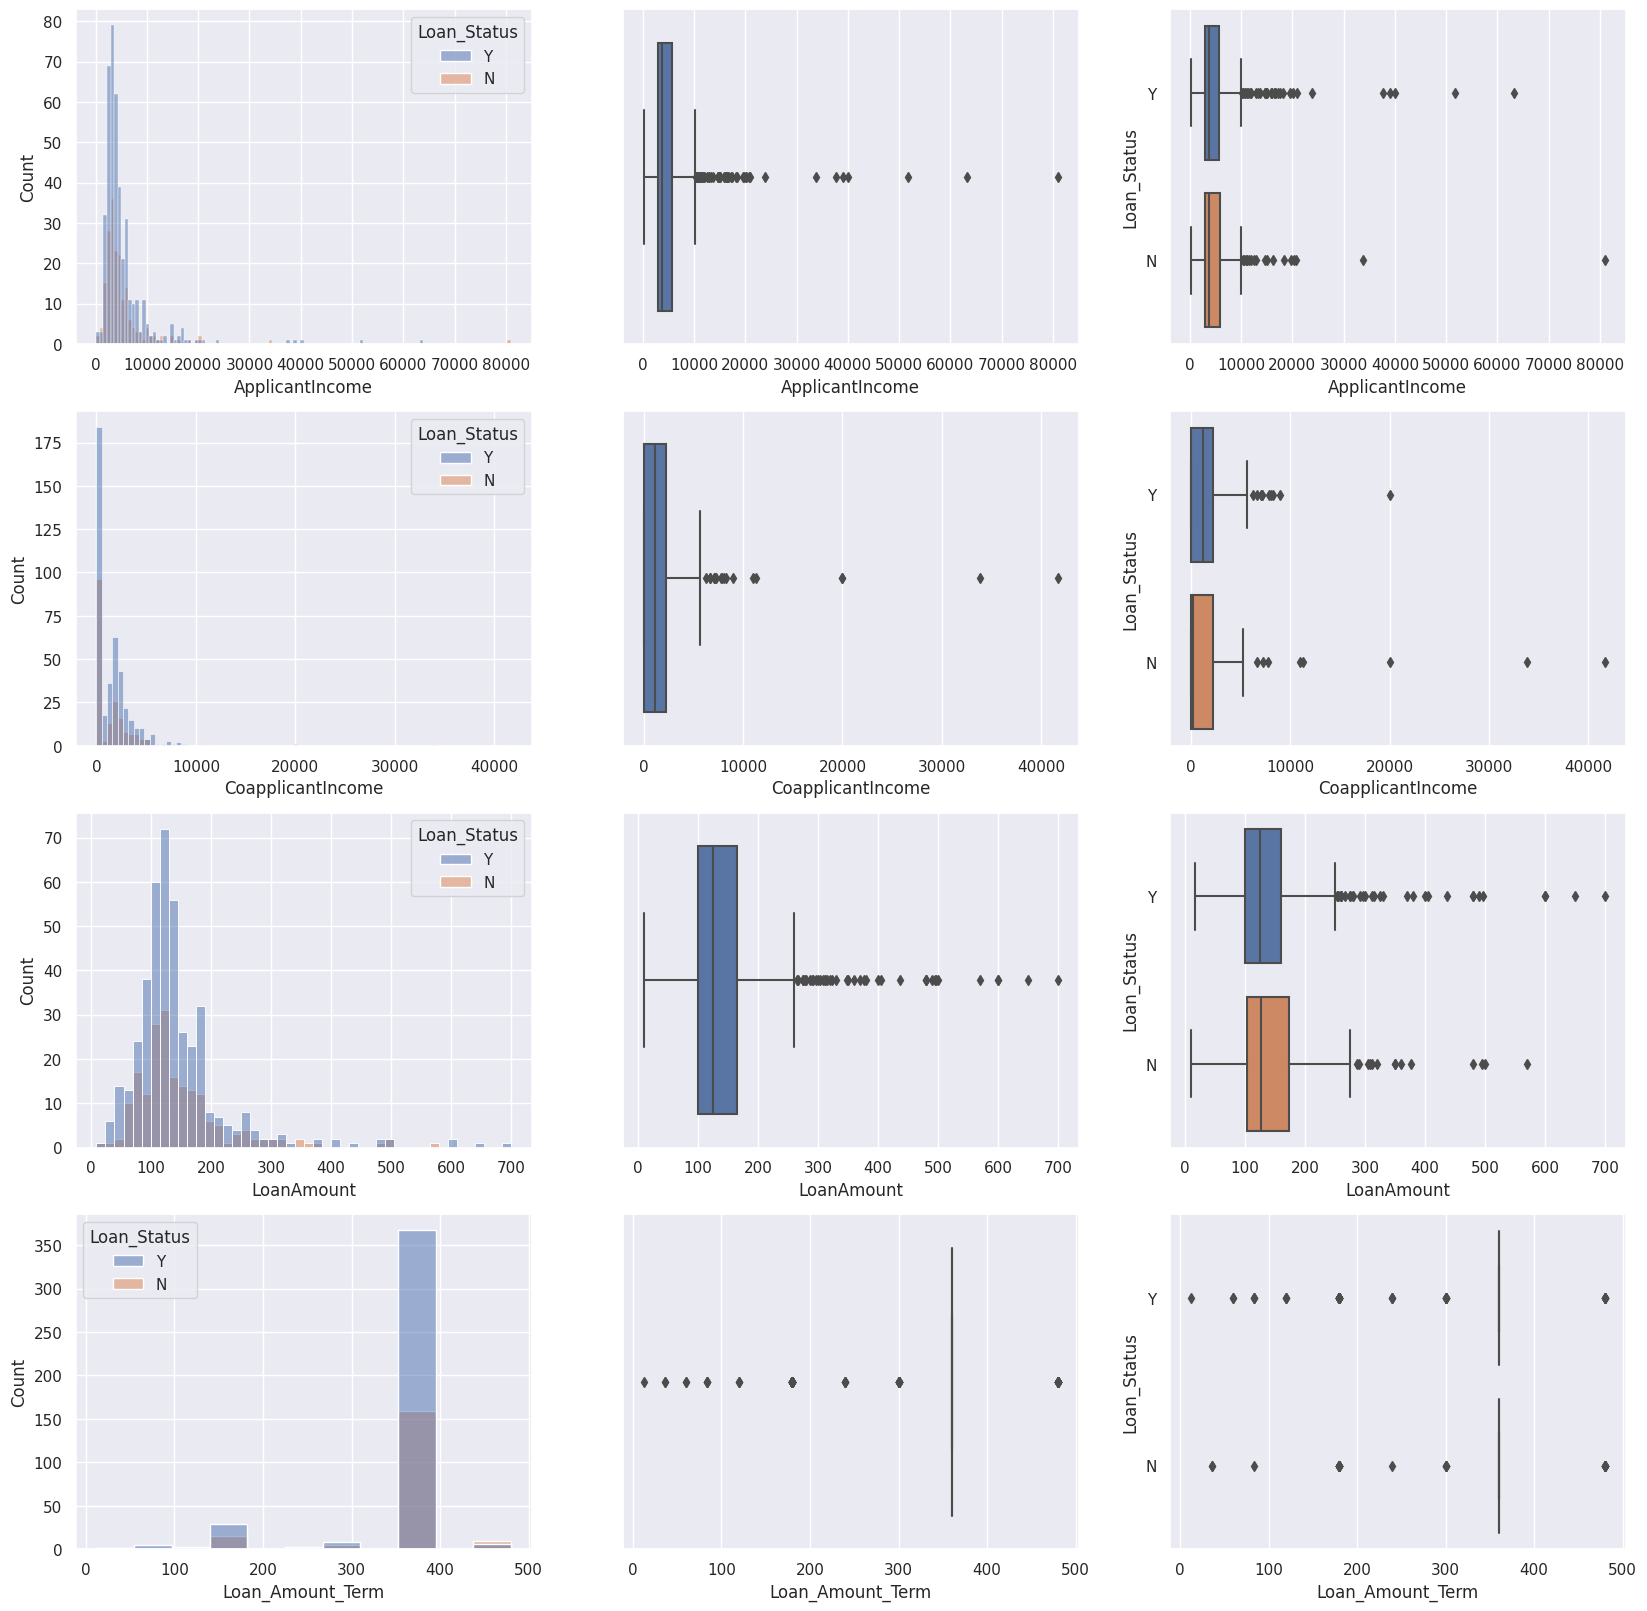

In [17]:
fig, axes = plt.subplots(4, 3,figsize=(20,20))
for idx, row in enumerate(axes):
    ax0, ax1, ax2 = row
    
    sns.histplot(x=numerical_features[idx], data=df_fe, hue=target_col, ax=ax0)
    sns.boxplot(x=numerical_features[idx], data=df_fe, ax=ax1)
    sns.boxplot(x=numerical_features[idx], y=target_col, data=df_fe, ax=ax2)

#### Binning

In [18]:
n_bins = 3
labels = ['low', 'medium', 'high']
df_fe['ApplicantIncome_binned'] = pd.qcut(df_fe['ApplicantIncome'], q= n_bins, labels=labels)

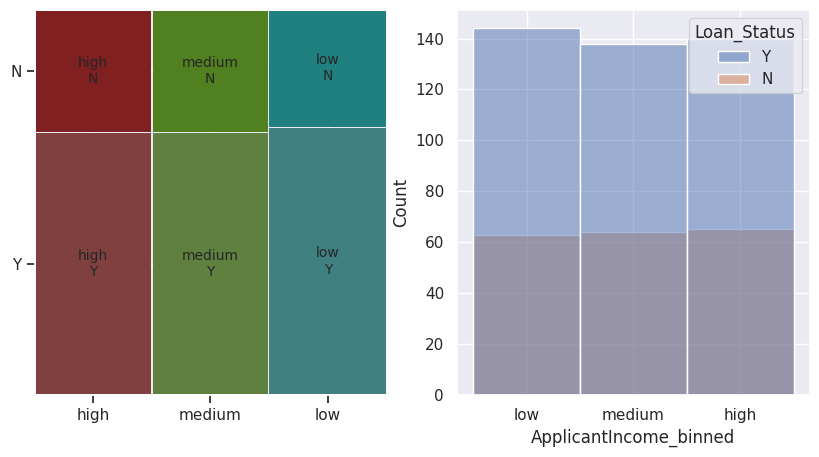

In [19]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,5))
mosaic(df_fe, ['ApplicantIncome_binned']+[target_col], ax=ax0)
sns.histplot(x='ApplicantIncome_binned',hue=target_col, data=df_fe, ax=ax1)
plt.show()

having low income seems to have a slight effect on the loan approval.

the variable `CoapplicantIncome` has alot of zero values so I am gonna bin `CoapplicantIncome` such that applicants with no `CoapplicantIncome` get a distinct category and the others are binned by quantiles into three categories.  

In [20]:
zero_values = df_fe[df_fe['CoapplicantIncome'] == 0]
non_zero_values = df_fe[df_fe['CoapplicantIncome'] != 0]

non_zero_values['CoapplicantIncome_binned'] = pd.qcut(non_zero_values['CoapplicantIncome'],\
                                                  q=n_bins, labels=labels)
zero_values['CoapplicantIncome_binned'] = 'no_income'
df_fe = pd.concat([zero_values, non_zero_values])

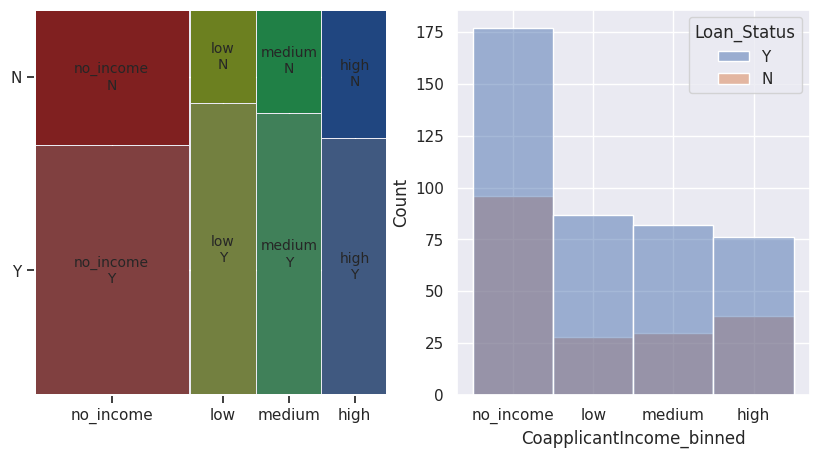

In [21]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,5))
mosaic(df_fe, ['CoapplicantIncome_binned']+[target_col], ax=ax0)
sns.histplot(x='CoapplicantIncome_binned',hue=target_col, data=df_fe, ax=ax1)
plt.show()

we can see that the effect of the `CoapplicantIncome_binned` variable on the loan approval such that applicants with no_income for `CoapplicantIncome_binned` have the lowest approvals while applicants with low `CoapplicantIncome_binned` have the highes approvals.

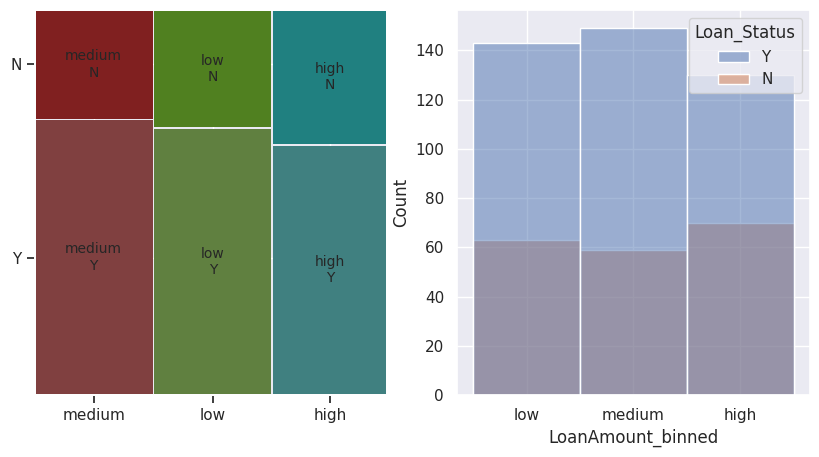

In [22]:
df_fe['LoanAmount_binned'] = pd.qcut(df_fe['LoanAmount'], q= n_bins, labels=labels)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,5))
mosaic(df_fe, ['LoanAmount_binned']+[target_col], ax=ax0)
sns.histplot(x='LoanAmount_binned',hue=target_col, data=df_fe, ax=ax1)
plt.show()

we can see that medium `LoanAmount_binned` has the highst number of approvals whils higt `LoanAmount_binned` has the lowest number.

now I am going to bin the variable `Loan_Amount_Term` into ony 2 categories because it has only 10 unique values

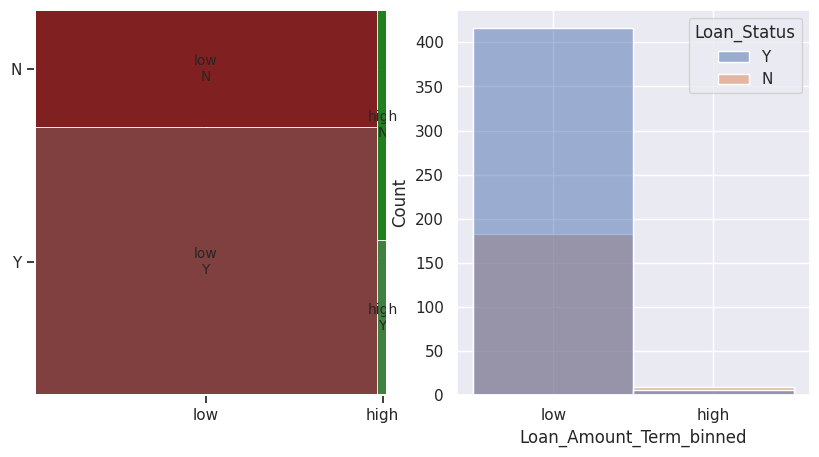

In [23]:
df_fe['Loan_Amount_Term_binned'] = pd.qcut(df_fe['Loan_Amount_Term'], q= 2, labels=['low', 'high'])

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,5))
mosaic(df_fe, ['Loan_Amount_Term_binned']+[target_col], ax=ax0)
sns.histplot(x='Loan_Amount_Term_binned',hue=target_col, data=df_fe, ax=ax1)
plt.show()

we can see that most majority of applicants have low `Loan_Amount_Term` but having high `Loan_Amount_Term` shrinks the number of approvals significatly

**now let's try out some interresting combinations of the variables**

#### variable combinations

In [24]:
df_fe['total_income'] = df_fe['ApplicantIncome'] + df_fe['CoapplicantIncome']
df_fe['installment'] = df_fe['LoanAmount'] + df_fe['Loan_Amount_Term']
fe_numerical_variables = ['total_income', 'installment']

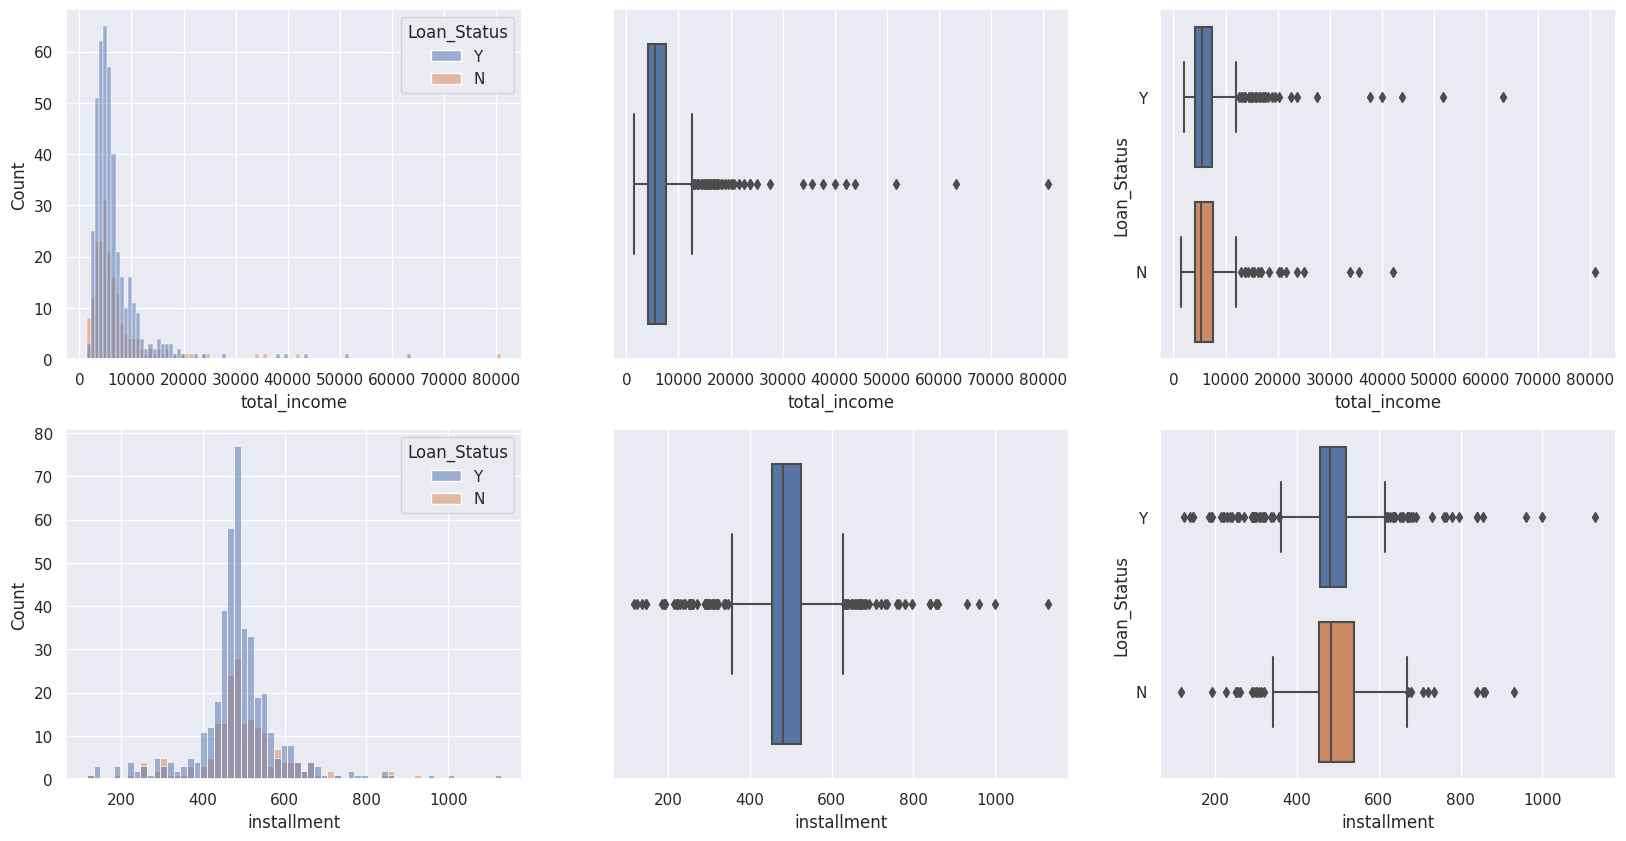

In [25]:
fig, axes = plt.subplots(2, 3,figsize=(20,10))
for idx, row in enumerate(axes):
    ax0, ax1, ax2 = row
    
    sns.histplot(x=fe_numerical_variables[idx], data=df_fe, hue=target_col, ax=ax0)
    sns.boxplot(x=fe_numerical_variables[idx], data=df_fe, ax=ax1)
    sns.boxplot(x=fe_numerical_variables[idx], y=target_col, data=df_fe, ax=ax2)

the `total_income` variable doesn't seem promising and also it's linear so it's not hard for the model to resemble it but the `installment` variable might be worth some further invistigation

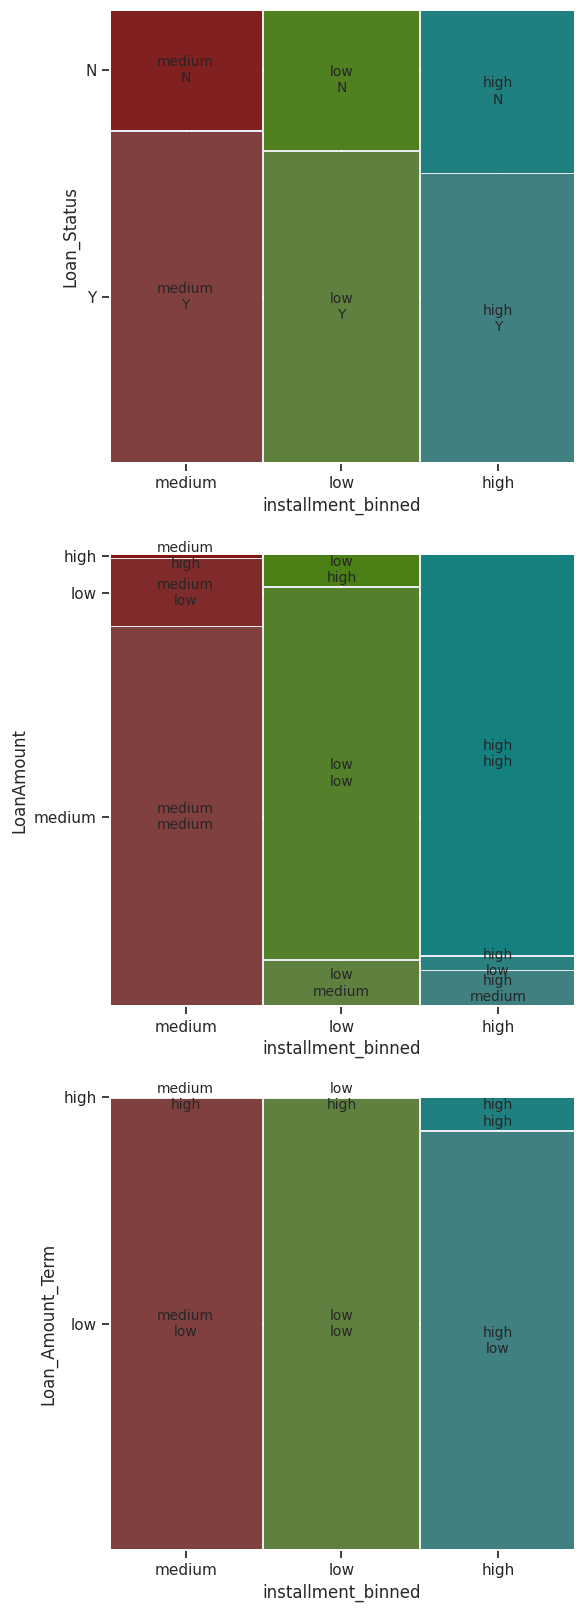

In [26]:
df_fe['installment_binned'] = pd.qcut(df_fe['installment'], q= n_bins, labels=labels)

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(6,20))

mosaic(df_fe, ['installment_binned']+[target_col], ax=ax0)
ax0.set(ylabel=target_col, xlabel='installment_binned')

mosaic(df_fe, ['installment_binned']+['LoanAmount_binned'], ax=ax1)
ax1.set(ylabel='LoanAmount', xlabel='installment_binned')

mosaic(df_fe, ['installment_binned']+['Loan_Amount_Term_binned'], ax=ax2)
ax2.set(ylabel='Loan_Amount_Term', xlabel='installment_binned')

plt.show()

it seems like it has an effect on the response variable and not linearly correlated with the other variables

In [27]:
# dropping the original variables befor binning
df_fe = df_fe.drop(numerical_features+fe_numerical_variables, axis=1)
df_fe.head()

,Married,Dependents,Education,Credit_History,Property_Area,Loan_Status,ApplicantIncome_binned,CoapplicantIncome_binned,LoanAmount_binned,Loan_Amount_Term_binned,installment_binned
0,No,0,Graduate,1.0,Urban,Y,high,no_income,medium,low,medium
2,Yes,0,Graduate,1.0,Urban,Y,low,no_income,low,low,low
4,No,0,Graduate,1.0,Urban,Y,high,no_income,medium,low,medium
15,No,0,Graduate,1.0,Urban,Y,high,no_income,medium,low,medium
16,No,1,Not Graduate,1.0,Urban,Y,medium,no_income,low,low,low


## Training 

### Baseline
we're going to train a logistic regression model on the data before the feature engineering to detrmine the performance baseline

In [28]:
x_baseline = pd.get_dummies(df_cleaned.drop(target_col, axis=1))
y_baseline = df_cleaned[target_col]

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

model = LogisticRegression()
scores = cross_val_score(model, x_baseline, y_baseline, scoring='accuracy', cv=10)

print('Scores: ', scores.tolist())
print('\nAverage Score: ', np.average(scores))

Scores:  [0.8064516129032258, 0.8225806451612904, 0.7419354838709677, 0.7580645161290323, 0.7868852459016393, 0.7868852459016393, 0.8688524590163934, 0.8524590163934426, 0.7868852459016393, 0.8360655737704918]

Average Score:  0.8047065044949762


### Model

In [30]:
X = pd.get_dummies(df_fe.drop(target_col, axis=1))
Y = df_fe[target_col]

#### Logistic regression

In [31]:
lr = LogisticRegression()
scores = cross_val_score(lr, X, Y, scoring='accuracy', cv=10)

print('Scores: ', [round(score, 2) for score in scores.tolist()])
print('\nAverage Score: ', np.average(scores))

Scores:  [0.79, 0.76, 0.76, 0.82, 0.82, 0.8, 0.8, 0.84, 0.84, 0.8]

Average Score:  0.8030671602326812


In [32]:
lr_ridge = LogisticRegression(penalty='l2')
scores = cross_val_score(lr_ridge, X, Y, scoring='accuracy', cv=10)

print('Scores: ', [round(score, 2) for score in scores.tolist()])
print('\nAverage Score: ', np.average(scores))

Scores:  [0.79, 0.76, 0.76, 0.82, 0.82, 0.8, 0.8, 0.84, 0.84, 0.8]

Average Score:  0.8030671602326812


#### Random Forests

In [33]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=250)
scores = cross_val_score(rf, X, Y, scoring='accuracy', cv=10)

print('Scores: ', [round(score, 2) for score in scores.tolist()])
print('\nAverage Score: ', np.average(scores))

Scores:  [0.71, 0.65, 0.68, 0.81, 0.79, 0.74, 0.75, 0.79, 0.82, 0.77]

Average Score:  0.7494447382337388


#### Gradient Boosting

In [34]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=10)
scores = cross_val_score(gb, X, Y, scoring='accuracy', cv=10)

print('Scores: ', [round(score, 2) for score in scores.tolist()])
print('\nAverage Score: ', np.average(scores))

Scores:  [0.81, 0.76, 0.76, 0.85, 0.82, 0.79, 0.8, 0.84, 0.84, 0.8]

Average Score:  0.8062665256478054
